## Description project

We work here for a company specialised in E-commerce who exclusively sells handmade clothes. Management would like us to developp a tool that identifies fraudulent activities in a timely manner to prevent any theft.


#### Scope of work

- Determine user's country from his IP address
- Build a Machine Learning prediction model allowing to categorise a transaction as fraudulent or safe.
- Elaborate on how the model works for a non technical audience who wants to be comfortable using the model


To complete the work, we were provided with two datasets :
- Fraud_data, containing a sample of users with information such as sex, age, signup_time, ip_address ... and wether they commited fraud or not
- One table indicating country from a combination of the lower bound and upper bound of an IP address.

----- 


In [ ]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


In [ ]:
from config.config import *
from libs.common import *
//init_notebook_mode(connected=True)
print(tf.__version__) # requires version >= 1.9.0

In [ ]:
save_dir=f"{exps_dir}/exp4"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')

# Options

pd.set_option('display.max_columns', 500)


# Function for when we want to drop a column but still keep it in memory in an other dataframe

def to_recycle_bin(column) :
    recycle_ds[column] = dataset[column]
    dataset.drop(column, axis=1, inplace = True)
    
# Function to get a column back from recycle_ds

def restore_from_bin(column) :
    dataset[column] = dataset[column]
    recycle_ds.drop(column, axis=1, inplace = True)

# First we import the data

dataset = pd.read_csv(f"{data_dir}/fraud_ecommerce/Fraud_Data.csv")              # Users information
IP_table = pd.read_csv(f"{data_dir}/fraud_ecommerce/IpAddress_to_Country.csv")   # Country from IP information
recycle_ds = pd.DataFrame()

### Getting information from IP_table

In [2]:
# We want to get country related to each IP address

IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
    
# To affect a country to each IP :
# dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

# Since this code is time consuming to run, we have saved the result in a file with the following line of code :
# dataset.to_csv("../kaggle/input/datasets_fraud/Fraud_data_with_country.csv")

#which allows us to simply import the data if we need to restart the kernel
dataset = pd.read_csv("../input/datasets-fraud/Fraud_data_with_country.csv")

### Understanding the data

In [3]:
# We look at what our dataset looks like
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,24-02-2015 22:55:49,18-04-2015 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,07-06-2015 20:39:50,08-06-2015 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,01-01-2015 18:52:44,01-01-2015 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,28-04-2015 21:13:25,04-05-2015 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,United States
4,221365,21-07-2015 07:09:52,09-09-2015 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [4]:
# We look at the unique values for the relevant
import pprint
for colonne in ["purchase_value","source","browser","sex","age" ] :
    pprint.pprint("{} : {}".format(colonne, dataset[colonne].unique()))

('purchase_value : [ 34  16  15  44  39  42  11  27  30  62  13  58  18  50  '
 '57  55  40  46\n'
 '  24  47  25  52  31  37  54  12  48  56  72  38  33  53  35  60  91  26\n'
 '  75  51  81  69  36  10  14  29  21  61  41  19  28  65   9  79  23  73\n'
 '  45  20  78  22  32  68  43  82  59  70  63  86  80  66  49  17  64 107\n'
 '  87  67  76  90  88  92  77  85  71  74 101  96  93  98 123  89  84  94\n'
 '  83  99 118 103 112 105  97 120 100 109  95 106 110 102 115 119 111 108\n'
 ' 129 154 116 104 113 117 121 128 127 122 114 132 140 125]')
"source : ['SEO' 'Ads' 'Direct']"
"browser : ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']"
"sex : ['M' 'F']"
('age : [39 53 41 45 18 19 34 43 31 35 32 33 38 24 23 28 36 27 56 21 22 30 57 '
 '44\n'
 ' 40 55 37 20 48 25 46 29 26 47 60 52 42 49 50 58 51 59 62 54 68 64 61 63\n'
 ' 72 67 65 69 66 73 70 71 74 76]')


In [5]:
# Are there multiple lines with the same user_id ?
print("The user_id column includes {} duplicates".format(dataset.duplicated(subset = "user_id", keep =False).sum()))

The user_id column includes 0 duplicates


Conclusion : each row in the table has a unique user_id

In [6]:
# Let's see if the same device_id is sometimes used several times

dup_table = pd.DataFrame(dataset.duplicated(subset = "device_id"))
dup_rate = dup_table.mean()
print("{}% of the dataset is comprised of transactions from a device_id that had been previously used".format(int(dup_rate*1000)/10))

8.7% of the dataset is comprised of transactions from a device_id that had been previously used


In [7]:
# Since we know the same machine_id can be used for several transaction we will 
# look at how many times on average devices with duplicates are used and their distribution

dataset = pd.read_csv("../input/datasets-fraud/Fraud_data_with_country.csv")

device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
device_duplicates.reset_index(level=0, inplace= True)                                  # and then we turn device_id from index to column

dupli = device_duplicates[device_duplicates.freq_device >1]
print("On average, when a device is used more than once it is used {mean} times, and the most used machine was used {maxi} times"
      .format(mean = int(dupli.mean()*10)/10, maxi = int(dupli.freq_device.max()*10)/10))

dupli = device_duplicates[device_duplicates.freq_device >2]
print("On average, when a device is used more than twice it is used {mean} times"
      .format(mean = int(dupli.mean()*10)/10, maxi = int(dupli.freq_device.max()*10)/10))

# finally we merge with dataset
dataset = dataset.merge(device_duplicates, on= "device_id")


On average, when a device is used more than once it is used 3.1 times, and the most used machine was used 20.0 times
On average, when a device is used more than twice it is used 10.2 times


### Data exploration

In [8]:
# What is the proportion of fraud in the dataset
print("proportion of fraud in the dataset :" , int(dataset["class"].mean()*1000)/10,"%")

proportion of fraud in the dataset : 9.3 %


[[<matplotlib.axis.XTick at 0x7fcbff738da0>,

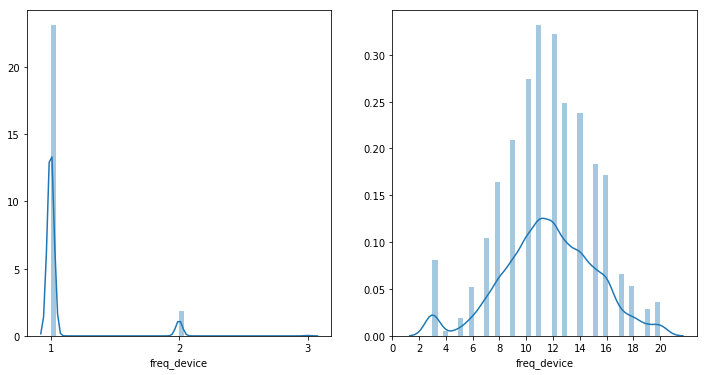

In [9]:
# Let's look at the device frequency distribution to confirm our intuition

f, ax = plt.subplots(1,2,figsize=(12,6))
g1 =sns.distplot(dataset.freq_device[dataset.freq_device <4], ax=ax[0])
g1.set(xticks=[1,2,3])

g2 =sns.distplot(dataset.freq_device[dataset.freq_device >2], ax=ax[1])
g2.set(xticks = range(0,21,2))

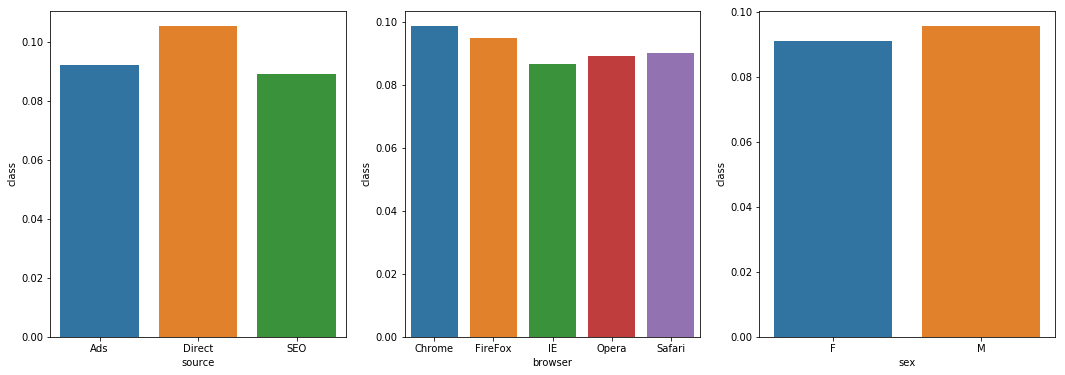

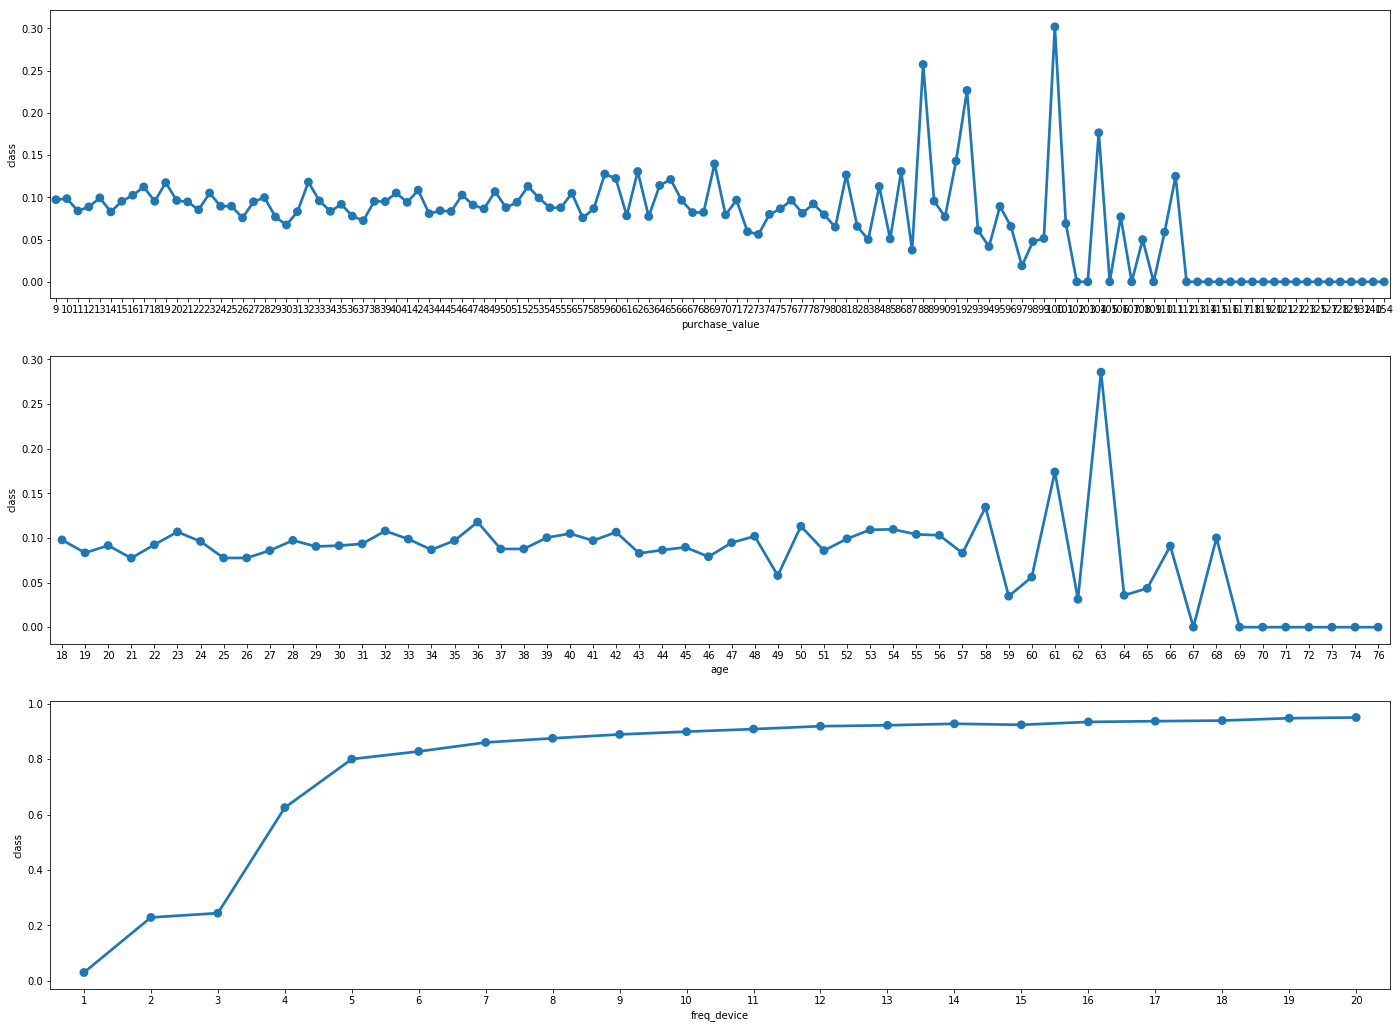

In [10]:
# We look at the likelihood of fraud per category

f, ax = plt.subplots(1,3, figsize =(18,6))
f2,ax2 = plt.subplots(3,1, figsize =(24,18))
sns.barplot(dataset.groupby(by = "source").mean()["class"].index, dataset.groupby(by = "source").mean()["class"], ax=ax[0])
sns.barplot(dataset.groupby(by = "browser").mean()["class"].index, dataset.groupby(by = "browser").mean()["class"], ax =ax[1])
sns.barplot(dataset.groupby(by = "sex").mean()["class"].index, dataset.groupby(by = "sex").mean()["class"], ax = ax[2])

sns.pointplot(x = "purchase_value", y= "class", data = dataset, logistic=True, ci=None, ax =ax2[0])
sns.pointplot(x = "age", y= "class", data = dataset, logistic=True, ci=None, ax = ax2[1])
sns.pointplot(x = "freq_device", y= "class", data = dataset, logistic=True, ci=None, ax=ax2[2])

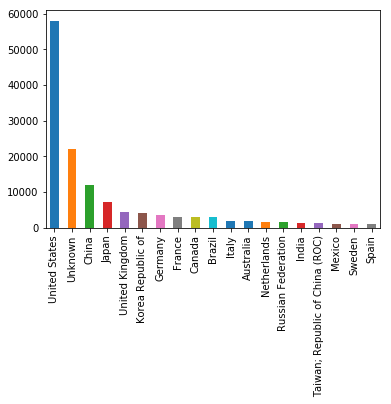

In [11]:
# Overview of distribution by country of origin

dataset.IP_country.value_counts()[dataset.IP_country.value_counts() >1000].plot(kind="bar")

# We note that we have a non negligible amount of Unknown. We keep this as an information as IP that cannot be traced back to a 
# country may be an indication of a fraudulent activity

### Features engineering

In [12]:
dataset = pd.read_csv("../input/datasets-fraud/Fraud_data_with_country.csv")
dataset = dataset.merge(device_duplicates, on= "device_id")

# --- 1 ---
# Categorisation column freq_device
# We see a clear correlation between freq_device and fraudulent activities. We are going to split freq_device in 7 categories
dataset.freq_device = dataset.freq_device.apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# We convert signup_time and purchase_time en datetime

dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%d-%m-%Y %H:%M:%S')
dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%d-%m-%Y %H:%M:%S')

# We add features 

# --- 2 ---
# Column month
dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 3 ---
# Column week
dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 4 ---
# Column hour_of_the_day
dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# --- 5 ---
# Column seconds_since_signup
dataset["seconds_since_signup"]= (dataset.purchase_time - dataset.signup_time).apply(lambda x : x.total_seconds())

# --- 6 ---
# Column countries_from_device (ie. number of different countries per device_id)

# We flag devices that committed purchases from different countries
# First we groupby device_id and IP_country which will give us a DF with a sublist of country for each device_id
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

# --- 7 ---
# Column risk_country which classifies each country based on historical fraud rate from these countries

# We calculate the proportion of fraud by country
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))

# We classify each country between Very High risk, High risk, Medium risk and low risk
risk_country["risk_country"] = risk_country["class"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")
                                                
# We merge with dataset
dataset = dataset.merge(risk_country.drop("class", axis = 1), left_on= "IP_country", right_index = True)

# --- 8 ---
# Column "quick_purchase" : categorise time between sign_up and purchase
dataset["quick_purchase"] = dataset.seconds_since_signup.apply(lambda x : 1 if x < 30 else 0)

# --- 9 ---
# Column freq_same_purchase : indicates how many times a given device_id purchased an item of the same value

# We generate a table indicating for each line if the couple device_id / purchase_value has duplicates
duplicate = dataset.duplicated(subset = ["purchase_value","device_id"], keep = False)
# We merge it with a DF containing purchase_value and device_id
duplicate = pd.concat([dataset.loc[:,["purchase_value","device_id"]], duplicate],axis=1)
# We build a DataFrame which gives us the number of duplicates for each combination of device_id / purchase_value
duplicate = duplicate.groupby(by = ["device_id","purchase_value"]).sum()
# We categorise number of time the same purchase has been made 
duplicate["freq_same_purchase"] = duplicate[0].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )
                                            
# We merge the result with main dataset            
dataset.merge(duplicate.drop(0,axis=1), left_on=["device_id","purchase_value"], right_index = True)

# --- 10 ---- 
# age categorisation

dataset["age_category"] = dataset.age.apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

# ---- 11 ----
# Hour of the day categorisation
dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

# ---- 12 -----
# First_purchase 

# Assuming a potential scammer would want to check out the website before committing any fraudulent activity
# we want to know if for a given device_ID if the row corresponds to a first operation or not

# However the following code take a long time to run! That's why we have save the resulting Series in the file 
# Series_first_purchase.csv to prevent waiting time when we reset the kernel

# Original code :
#dataset["first_purchase"] = dataset.apply(lambda x : 
 #                                         1 if x.purchase_time == dataset.purchase_time[dataset.device_id == x.device_id].min() else 0,
 #                                         axis =1)
#dataset.first_purchase.to_csv("datasets/Series_first_purchase.csv",index =False)

dataset["first_purchase"] = pd.read_csv("../input/datasets-fraud/Series_first_purchase.csv", )


dataset.to_csv("../data_with_first_feature_eng.csv")

### Visualisation post feature engineering

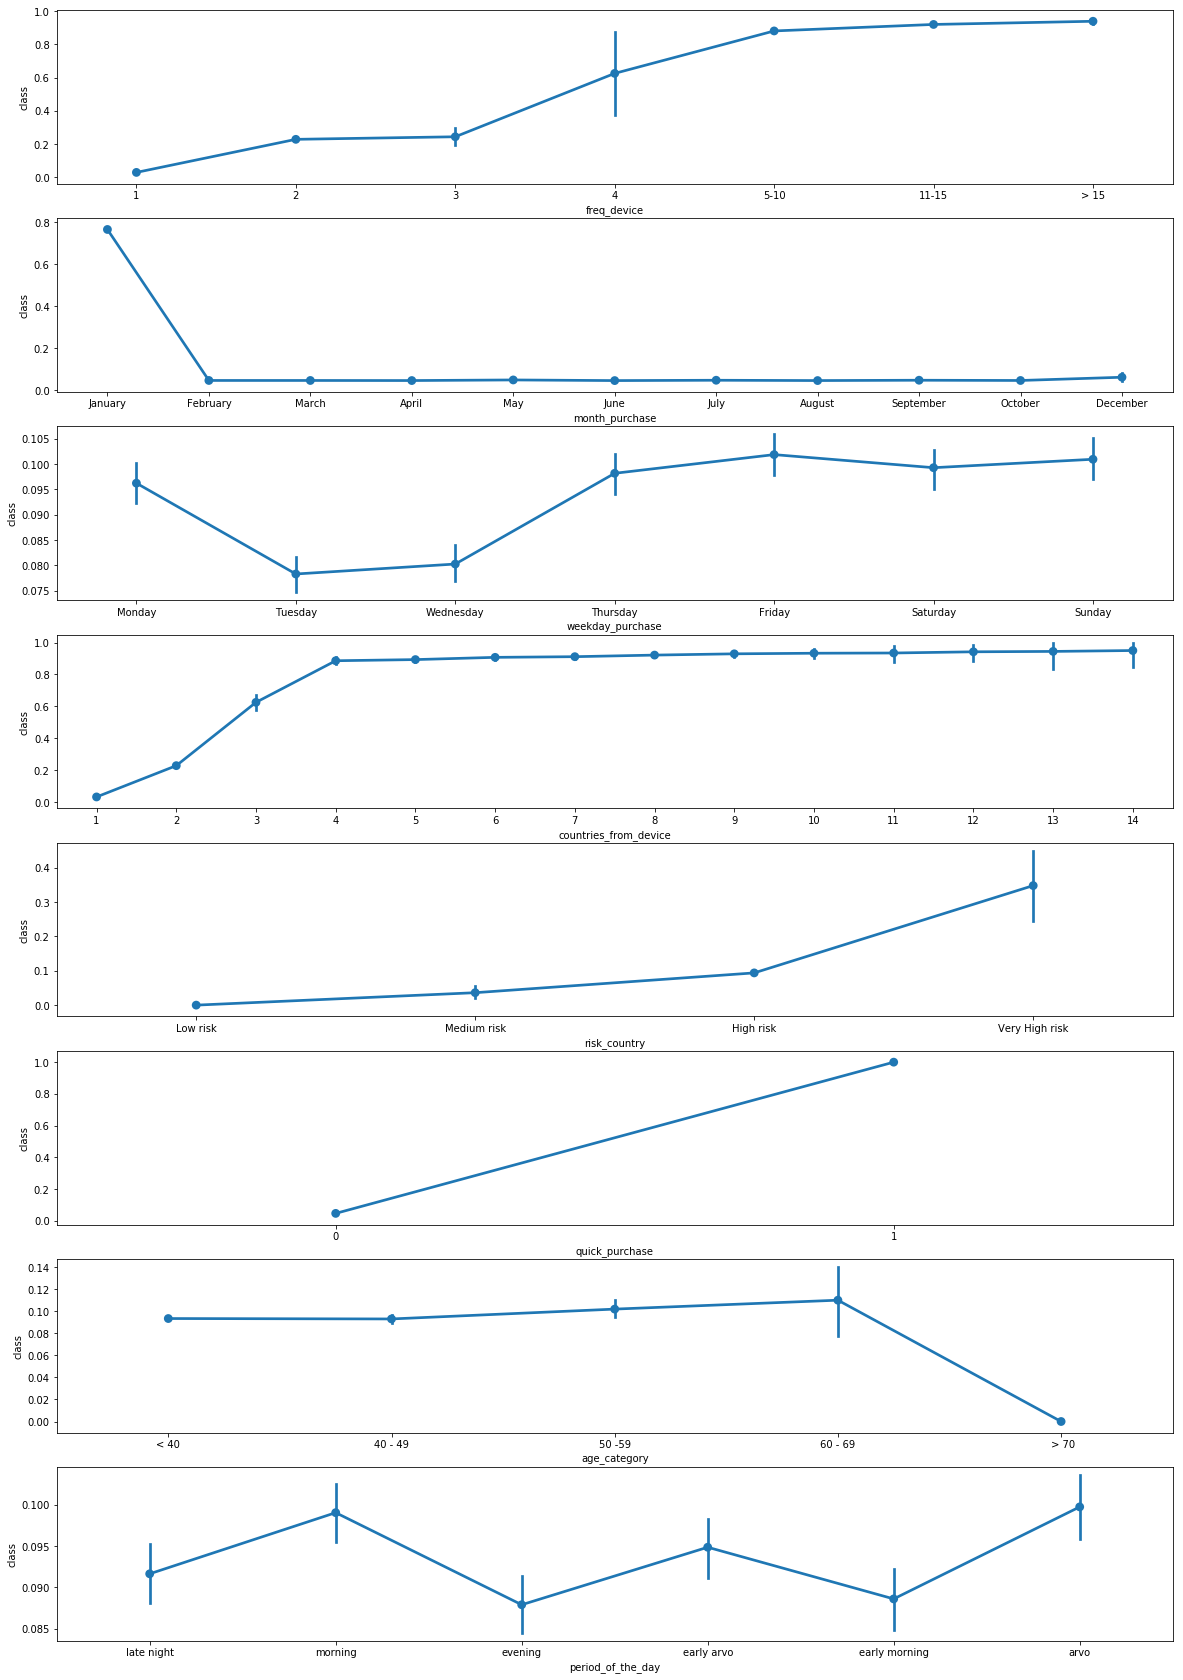

In [13]:
liste_col = ["freq_device", "month_purchase", "weekday_purchase",
                "countries_from_device", "risk_country", "quick_purchase",
                "age_category","period_of_the_day"]

f, ax = plt.subplots(len(liste_col),1, figsize = (20 , 30))

param_order = {"freq_device":["1","2","3","4","5-10","11-15","> 15"],
              "month_purchase":["January", "February", "March", "April","May", "June", "July", "August", "September", "October", "December"],
              "weekday_purchase" : ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
              "risk_country": ["Low risk", "Medium risk", "High risk", "Very High risk"],
              "Period_of_the_day" : ["morning", "early arvo", "arvo", "evening", "late night", "early morning"]}

for i, colonne in enumerate(liste_col) :
    sns.catplot(x = colonne, y = "class", data = dataset, kind ="point", order= param_order.get(colonne), ax =ax[i], xlabel = colonne, figsize =(40,20))
    plt.close(2)

In [14]:
dataset = pd.read_csv("../data_with_first_feature_eng.csv",index_col=0)

# Following the trends on the above chart we decide to add a specific variable to spot if the transaction occured in January
dataset["is_january"] = dataset.weekday_purchase.apply(lambda x : 1 if x == "January" else 0)


In [15]:
# We get rid of useless columns

for colonne in ["user_id",
                "signup_time",
                "purchase_time",
                "device_id",
                "ip_address",
                "IP_country",
                "hour_of_the_day",
               "seconds_since_signup",
               "age"] :
    to_recycle_bin(colonne)
    
dataset.dropna(inplace = True)

### -----------------------------------  Linear models  ---------------------------------------------------

(which need to avoid colinearity of the variable, ie get_dummies(drop_first = True)

In [16]:
X = pd.get_dummies(dataset.drop("class", axis=1),drop_first= True)
y = dataset["class"]
# we split between train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size = 0.25
                                                   )

# We normalise X_train et X_test 

from sklearn.preprocessing import StandardScaler
StdS = StandardScaler()

X_train = StdS.fit_transform(X_train)
X_test = StdS.transform(X_test)

 score sur train :  95.6 % score sur test :  95.6 %
sum y_pred 3457  with a threshold of 22.0 % score sur test :  93.5 %


Text(15.0, 0.5, 'True')

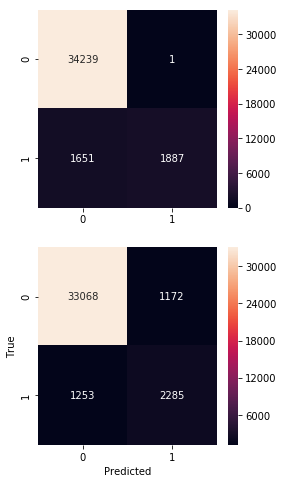

In [17]:
# We test a logistic regression first

from sklearn.linear_model import LogisticRegression
LogR = LogisticRegression()
LogR.fit(X_train, y_train)

print(
    " score sur train : ", int(LogR.score(X_train, y_train)*1000)/10, "%"
    " score sur test : " , int(LogR.score(X_test, y_test)*1000)/10, "%"
)

# Set up probabilite threshold
prob_threshold = 0.22

y_pred = pd.DataFrame(LogR.predict_proba(X_test), columns = ["proba_no_fraud", "proba_fraud"]).drop("proba_no_fraud", axis = 1)
y_pred = y_pred.proba_fraud.apply(lambda x : 0 if x < prob_threshold else 1)

score_threshold_test = np.mean(np.array(y_pred) == np.array(y_test))

print("sum y_pred", sum(y_pred),
    " with a threshold of", prob_threshold*100, "%"
    " score sur test : ", int(score_threshold_test*1000)/10,"%"
)

# Confusion matrix

f, ax = plt.subplots(2,1, figsize =(4,8))

# Matrix with threshold by default (50%)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, LogR.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", ax = ax[0])
plt.xlabel('Predicted')
plt.ylabel('True')

# Matrix with personalised threshold
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax = ax[1])
plt.xlabel('Predicted')
plt.ylabel('True')

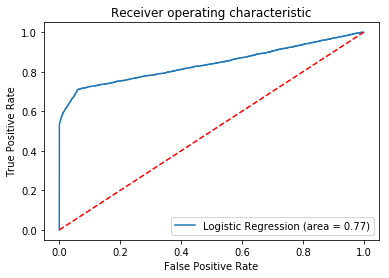

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, LogR.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogR.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### First conclusion :
Based on client's needs, we would be able to set the appropriate level of threshold to reduce the number of false negative (ie. fraud not detected) without increasing inappropriately the cost of false positive (blocked transaction which were not fraudulent)

Since the USA are the most represented country, we will try to apply the logistic regression to a dataset including only US and on a dataset with other countries. Except for that, the code will be excactly the same as above

 score sur train :  95.6 % score sur test :  95.5 %
sum y_pred 1427  with a threshold of 22.0 % score sur test :  93.1 %


Text(15.0, 0.5, 'True')

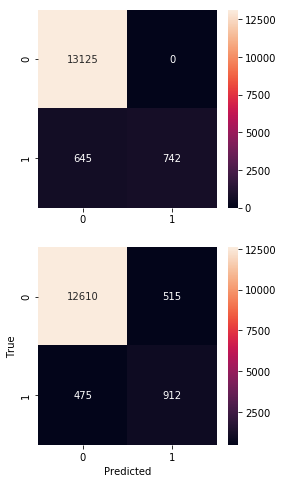

In [19]:
dataset = pd.read_csv("../data_with_first_feature_eng.csv",index_col=0)

# Following the trends on the above chart we decide to add a specific variable to spot if the transaction occured in January
dataset["is_january"] = dataset.weekday_purchase.apply(lambda x : 1 if x == "January" else 0)

# WE FILTER ON USA
dataset = dataset[dataset.IP_country == "United States"]

# We get rid of useless columns

for colonne in ["user_id",
                "signup_time",
                "purchase_time",
                "device_id",
                "ip_address",
                "IP_country",
                "hour_of_the_day",
               "seconds_since_signup",
               "age"] :
    to_recycle_bin(colonne)

dataset.dropna(inplace =True)    
    
X = pd.get_dummies(dataset.drop("class", axis=1),drop_first= True)
y = dataset["class"]
# we split between train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size = 0.25
                                                   )

# We normalise X_train et X_test 

from sklearn.preprocessing import StandardScaler
StdS = StandardScaler()

X_train = StdS.fit_transform(X_train)
X_test = StdS.transform(X_test)

# We test a logistic regression first

from sklearn.linear_model import LogisticRegression
LogR = LogisticRegression()
LogR.fit(X_train, y_train)

print(
    " score sur train : ", int(LogR.score(X_train, y_train)*1000)/10, "%"
    " score sur test : " , int(LogR.score(X_test, y_test)*1000)/10, "%"
)

# Set up probabilite threshold
prob_threshold = 0.22

y_pred = pd.DataFrame(LogR.predict_proba(X_test), columns = ["proba_no_fraud", "proba_fraud"]).drop("proba_no_fraud", axis = 1)
y_pred = y_pred.proba_fraud.apply(lambda x : 0 if x < prob_threshold else 1)

score_threshold_test = np.mean(np.array(y_pred) == np.array(y_test))

print("sum y_pred", sum(y_pred),
    " with a threshold of", prob_threshold*100, "%"
    " score sur test : ", int(score_threshold_test*1000)/10,"%"
)

# Confusion matrix

f, ax = plt.subplots(2,1, figsize =(4,8))

# Matrix with threshold by default (50%)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, LogR.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", ax = ax[0])
plt.xlabel('Predicted')
plt.ylabel('True')

# Matrix with personalised threshold
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax = ax[1])
plt.xlabel('Predicted')
plt.ylabel('True')

### Conclusion 
Applying the model on USA only does not yield different results than on the whole dataset

In [20]:
#To improve our score we can try to do a bit of stacking on the logistic regression

# -------- On predict_proba --------

LogR2 = LogisticRegression()
LogR2.fit(X_train, y_train)
X_train = pd.DataFrame(X_train)
X_train_new = pd.concat([pd.DataFrame(X_train), pd.DataFrame(LogR2.predict_proba(X_train))], axis =1)
X_test_new = pd.concat([pd.DataFrame(X_test), pd.DataFrame(LogR2.predict_proba(X_test))], axis = 1)

LogR2.fit(X_train_new, y_train)
list_scores = list()

for _ in np.arange(1,10) :
    list_scores.append([np.round(LogR2.score(X_train_new, y_train),5) , np.round(LogR2.score(X_test_new, y_test),5)])
    X_train_new = pd.concat([pd.DataFrame(X_train_new), pd.DataFrame(LogR2.predict_proba(X_train_new))], axis = 1)
    X_test_new = pd.concat([pd.DataFrame(X_test_new), pd.DataFrame(LogR2.predict_proba(X_test_new))], axis = 1)
    LogR2.fit(X_train_new, y_train)

print ("Stacking using predict_proba")
for num, element in enumerate(list_scores) :
    print ("score on iteration {} for train is : {} and for test is {}".format(num , element[0], element[1]))

# ------ Same thing but on predict_ (ie. 1 or 0 )  -------

LogR2 = LogisticRegression()
LogR2.fit(X_train, y_train)
X_train_new = pd.concat([pd.DataFrame(X_train), pd.DataFrame(LogR2.predict(X_train))], axis =1)
X_test_new = pd.concat([pd.DataFrame(X_test), pd.DataFrame(LogR2.predict(X_test))], axis = 1)

LogR2.fit(X_train_new, y_train)
list_scores = list()

for _ in np.arange(1,10) :
    list_scores.append([np.round(LogR2.score(X_train_new, y_train),5) , np.round(LogR2.score(X_test_new, y_test),5)])
    X_train_new = pd.concat([pd.DataFrame(X_train_new), pd.DataFrame(LogR2.predict(X_train_new))], axis = 1)
    X_test_new = pd.concat([pd.DataFrame(X_test_new), pd.DataFrame(LogR2.predict(X_test_new))], axis = 1)
    LogR2.fit(X_train_new, y_train)   
    
print ("Stacking using predict (1 or 0)")
for num, element in enumerate(list_scores) :
    print ("score on iteration {} for train is : {} and for test is {}".format(num , element[0], element[1]))

Stacking using predict_proba
score on iteration 0 for train is : 0.95604 and for test is 0.95555
score on iteration 1 for train is : 0.95604 and for test is 0.95555
score on iteration 2 for train is : 0.95604 and for test is 0.95555
score on iteration 3 for train is : 0.95604 and for test is 0.95555
score on iteration 4 for train is : 0.95604 and for test is 0.95555
score on iteration 5 for train is : 0.95604 and for test is 0.95555
score on iteration 6 for train is : 0.95604 and for test is 0.95555
score on iteration 7 for train is : 0.95604 and for test is 0.95555
score on iteration 8 for train is : 0.95604 and for test is 0.95555
Stacking using predict (1 or 0)
score on iteration 0 for train is : 0.95604 and for test is 0.95555
score on iteration 1 for train is : 0.95604 and for test is 0.95555
score on iteration 2 for train is : 0.95604 and for test is 0.95555
score on iteration 3 for train is : 0.95604 and for test is 0.95555
score on iteration 4 for train is : 0.95604 and for tes

#### Conclusion : 
Stacking has close to no effect on our Logistic Regression model

### -----------------------------------  NON- Linear models  ---------------------------------------------------

(which need to avoid colinearity of the variable, ie get_dummies(drop_first = False)

Before moving into more complex model, we are going to use a Lasso model on our set of data and use the results to strip out variables with coefficients = 0. This will hopefully allow us to drastically reduce computation time when using more complex models on this new dataset and then allow us to test more interesting approaches.

In [21]:
from sklearn.linear_model import LassoCV
LasReg = LassoCV()
LasReg.fit(X_train, y_train)

# We get an array of boolean giving us the information if Lasso coefficient is equal to 0 or not
Lasso_filter = LasReg.coef_ == 0

# We use that "filter" to reduce our X
Lasso_filter = X.loc[:,Lasso_filter].columns

# We create a new set of X and y, this time keeping the first columns of the dummified variables
X2 = pd.get_dummies(dataset.drop("class", axis=1),drop_first= False)
y2 = dataset["class"]

# And we now use our Lasso_filter
X2 = X2.drop(Lasso_filter, axis = 1)

# we split between train and test

from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size = 0.3
                                                   )

# We normalise X_train et X_test 

from sklearn.preprocessing import StandardScaler
StdS = StandardScaler()

X_train2 = StdS.fit_transform(X_train2)
X_test2 = StdS.transform(X_test2)

In [22]:
print("number columns X", len(X.columns), "number columns X2", len( X2.columns))

number columns X 44 number columns X2 22


We have reduced by half the number of variables !
##### Nota Bene :
For the sake of validating our approach, we have re-run our previous Linear model on X.drop(Lasso_filter) with very similar score results as with X

In [23]:
# We tried to do a gridseacrh on XG boost but this did not yield better scores than the logistic regression


from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

rtc = XGBClassifier(n_jobs = -1, random_state =42)
params = {'max_depth' : np.arange(1,6),
          "learning_rate" : np.arange(0.1,0.5,0.05),
          "n_estimators" : np.arange(10,100,10)}

grid =  GridSearchCV(estimator=rtc,       # On indique le type d'estimator que l'on veut tester
                     param_grid= params,  # On indique le dictionnaire des parametres a faire varier (cf ci-dessus)
                     cv = 10,             # Le nombre de sous echantillon sur lequel le modele va tourner
                    n_jobs =-1)      

# CAREFUL TIME TO RUN THE BELOW IS VERY LONG
# grid.fit(X_train2, y_train2)

In [24]:
# Grid search on Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rtc = RandomForestClassifier()
params = {'max_depth' : np.arange(1,5),
         'min_samples_leaf' : [1, 5, 10, 20],
         "n_estimators" : np.arange(10,100,20)}

grid =  GridSearchCV(estimator=rtc,       # On indique le type d'estimator que l'on veut tester
                     param_grid= params,  # On indique le dictionnaire des parametres a faire varier (cf ci-dessus)
                     cv = 10,             # Le nombre de sous echantillon sur lequel le modele va tourner
                    n_jobs =-1)           # Permet de faire tourner tous les processeurs de l'ordinateur en parallele
grid.fit(X_train2, y_train2)

print("score train: ", round(grid.score(X_train2, y_train2),5), "score test : ", round(grid.score(X_test2, y_test2),5)) 

best_params = grid.best_estimator_.get_params()

score train:  0.95629 score test :  0.95504


 score sur train :  0.95629  score sur test :  0.95504


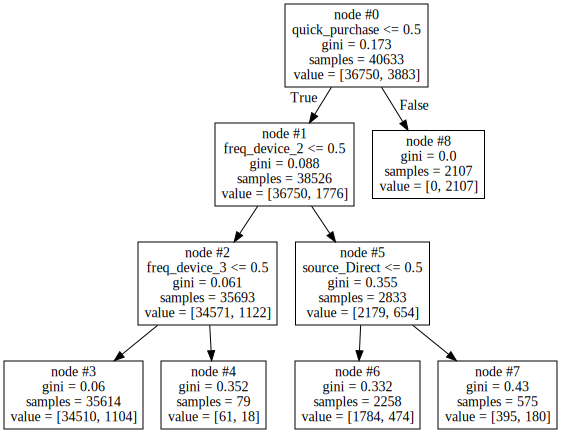

In [25]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X2, y2,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size = 0.3
                                                   )

# Simple Regression Tree

from sklearn.tree import DecisionTreeClassifier
classifier_gini = DecisionTreeClassifier(criterion=best_params["criterion"],
                                         max_depth = 3,       
                                         min_samples_leaf = best_params["min_samples_leaf"],  
                                        )
arbre = classifier_gini.fit(X_train3,y_train3)
print(
    " score sur train : ", np.round(classifier_gini.score(X_train3, y_train3),5),
    " score sur test : " , np.round(classifier_gini.score(X_test3, y_test3),5)
)

import graphviz
from sklearn import tree

graph_arbre = tree.export_graphviz(arbre, node_ids="box", feature_names = X2.columns)
graphviz.Source(graph_arbre)

### Conclusion
We see from that tree that :
1. all transaction with a quick purchase = 1 are classified as fraudulent
2. keeping "freq_device" as a numerical would have been better to get a clearer tree as different instances of freq_devices are used to split data between knots

Ideas to go further that may or may not improve the predictions :
- Combine models with rules like (if quick_purchase ==1 then prediction = 1)